In [42]:
import argparse

import cv2
import numpy as np
import torch

from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
from val import normalize, pad_width

from modules.one_euro_filter import OneEuroFilter
from modules.keypoints import BODY_PARTS_KPT_IDS, BODY_PARTS_PAF_IDS

import matplotlib as plt
from matplotlib import cm

In [43]:
from demo import *

The pose may contain up to 18 keypoints: ears, eyes, nose, neck, shoulders, elbows, wrists, hips, knees, and ankles.

For  multi-person  pose  es-timation,  most  approaches have  used  a  top-down  strategy  that  firstdetects  people  and  then  have  estimated  the  pose  of  eachperson  independently  on  each  detected  region

<img src="images/openpose_pipeline.png">

In [83]:
class Pose:
    num_kpts = 18
    kpt_names = ['nose', 'neck',
                 'r_sho', 'r_elb', 'r_wri', 'l_sho', 'l_elb', 'l_wri',
                 'r_hip', 'r_knee', 'r_ank', 'l_hip', 'l_knee', 'l_ank',
                 'r_eye', 'l_eye',
                 'r_ear', 'l_ear']
    sigmas = np.array([.26, .79, .79, .72, .62, .79, .72, .62, 1.07, .87, .89, 1.07, .87, .89, .25, .25, .35, .35],
                      dtype=np.float32) / 10.0
    vars = (sigmas * 2) ** 2
    last_id = -1
    color = [0, 0, 255]

    def __init__(self, keypoints, confidence):
        super().__init__()
        self.keypoints = keypoints
        self.confidence = confidence
        self.bbox = Pose.get_bbox(self.keypoints)
        self.id = None
        self.filters = [[OneEuroFilter(), OneEuroFilter()] for _ in range(Pose.num_kpts)]

    @staticmethod
    def get_bbox(keypoints):
        found_keypoints = np.zeros((np.count_nonzero(keypoints[:, 0] != -1), 2), dtype=np.int32)
        found_kpt_id = 0
        for kpt_id in range(Pose.num_kpts):
            if keypoints[kpt_id, 0] == -1:
                continue
            found_keypoints[found_kpt_id] = keypoints[kpt_id]
            found_kpt_id += 1
        bbox = cv2.boundingRect(found_keypoints)
        return bbox

    def update_id(self, id=None):
        self.id = id
        if self.id is None:
            self.id = Pose.last_id + 1
            Pose.last_id += 1

    def draw(self, img, color=Pose.color):
        assert self.keypoints.shape == (Pose.num_kpts, 2)

        for part_id in range(len(BODY_PARTS_PAF_IDS) - 2):
            kpt_a_id = BODY_PARTS_KPT_IDS[part_id][0]
            global_kpt_a_id = self.keypoints[kpt_a_id, 0]
            if global_kpt_a_id != -1:
                x_a, y_a = self.keypoints[kpt_a_id]
                cv2.circle(img, (int(x_a), int(y_a)), 3, color, -1)
            kpt_b_id = BODY_PARTS_KPT_IDS[part_id][1]
            global_kpt_b_id = self.keypoints[kpt_b_id, 0]
            if global_kpt_b_id != -1:
                x_b, y_b = self.keypoints[kpt_b_id]
                cv2.circle(img, (int(x_b), int(y_b)), 3, Pose.color, -1)
            if global_kpt_a_id != -1 and global_kpt_b_id != -1:
                cv2.line(img, (int(x_a), int(y_a)), (int(x_b), int(y_b)), color, 3)

In [96]:
def run_demo(net, image_provider, height_size, cpu, track, smooth):
net = net.eval()
if not cpu:
net = net

stride = 8
upsample_ratio = 4
num_keypoints = Pose.num_kpts
previous_poses = []
delay = 33
for img in image_provider:
orig_img = img.copy()
heatmaps, pafs, scale, pad = infer_fast(net, img, height_size, stride, upsample_ratio, cpu)

total_keypoints_num = 0
all_keypoints_by_type = []
for kpt_idx in range(num_keypoints):  # 19th for bg
    total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs, demo=True)
for kpt_id in range(all_keypoints.shape[0]):
    all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
    all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
current_poses = []
for n in range(len(pose_entries)):
    if len(pose_entries[n]) == 0:
        continue
    pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
    for kpt_id in range(num_keypoints):
        if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
            pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
            pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
    pose = Pose(pose_keypoints, pose_entries[n][18])
    current_poses.append(pose)

if track:
    track_poses(previous_poses, current_poses, smooth=smooth)
    previous_poses = current_poses
for i, pose in enumerate(current_poses):
    pose.draw(img, np.array(colormap[i % len(colormap)])*255)
#         img = cv2.addWeighted(orig_img, 0.8, img, 0.4, 0)
#         for pose in current_poses:
#             cv2.rectangle(img, (pose.bbox[0], pose.bbox[1]),
#                           (pose.bbox[0] + pose.bbox[2], pose.bbox[1] + pose.bbox[3]), (0, 255, 0))
#             if track:
#                 cv2.putText(img, 'id: {}'.format(pose.id), (pose.bbox[0], pose.bbox[1] - 16),
#                             cv2.FONT_HERSHEY_COMPLEX, 12, (0, 0, 255))

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
key = cv2.waitKey(delay)
if key == 27:  # esc
    return
elif key == 112:  # 'p'
    if delay == 33:
        delay = 0
    else:
        delay = 33

In [97]:
np.array(colormap[0]) *25

array([ 3.03921569, 11.66666667, 17.64705882])

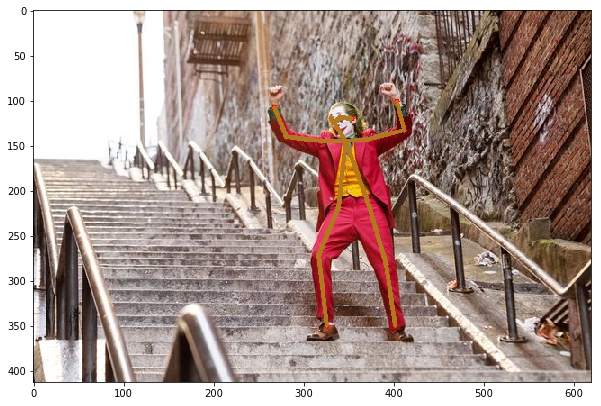

In [98]:
plt.figure(figsize=[10,10])
colormap = cm.tab10.colors

net = PoseEstimationWithMobileNet()
checkpoint = torch.load('model/checkpoint_iter_370000.pth', map_location='cpu')
load_state(net, checkpoint)
frame_provider = ImageReader(['images/joker.jpeg'])
run_demo(net, frame_provider, 512, True, 1, 1)

In [ ]:
class ImageReader(object):
    def __init__(self, file_names):
        self.file_names = file_names
        self.max_idx = len(file_names)

    def __iter__(self):
        self.idx = 0
        return self

    def __next__(self):
        if self.idx == self.max_idx:
            raise StopIteration
        img = cv2.imread(self.file_names[self.idx], cv2.IMREAD_COLOR)
        if img.size == 0:
            raise IOError('Image {} cannot be read'.format(self.file_names[self.idx]))
        self.idx = self.idx + 1
        return img

In [100]:
net = net.eval()

img = cv2.imread('images/joker.jpeg', cv2.IMREAD_COLOR)

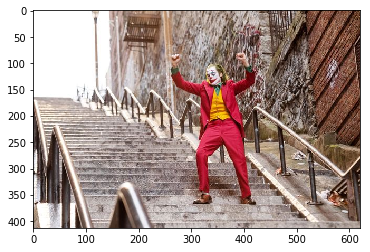

In [104]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [150]:
stride = 8
upsample_ratio = 8
num_keypoints = Pose.num_kpts
# previous_poses = []
# delay = 33
# for img in image_provider:
orig_img = img.copy()

heatmaps, pafs, scale, pad = infer_fast(net, img, 512, stride, upsample_ratio, cpu=True)

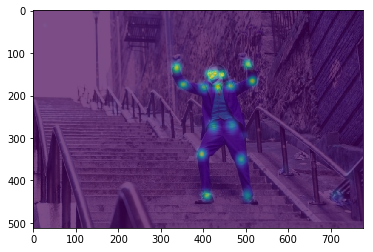

In [242]:
plt.imshow(np.max(heatmaps[:,:,:18], axis=2))
plt.imshow(cv2.resize(img, (776,512)), alpha=0.3)

In [250]:
pafs[:, :, 0] == (1- pafs[:, :, 1])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

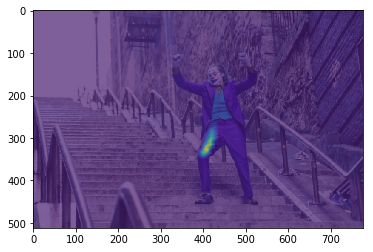

In [251]:
plt.imshow(1 - pafs[:,:,2])
plt.imshow(cv2.resize(img, (776,512)), alpha=0.3)

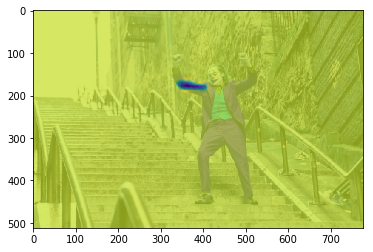

In [290]:
plt.imshow(pafs[:,:,14])
plt.imshow(cv2.resize(img, (776,512)), alpha=0.3)

In [276]:
pafs.max() - pafs.min()

2.3803723

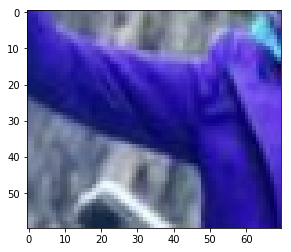

In [286]:
plt.imshow(cv2.resize(img, (776,512))[160:220, 350:420])

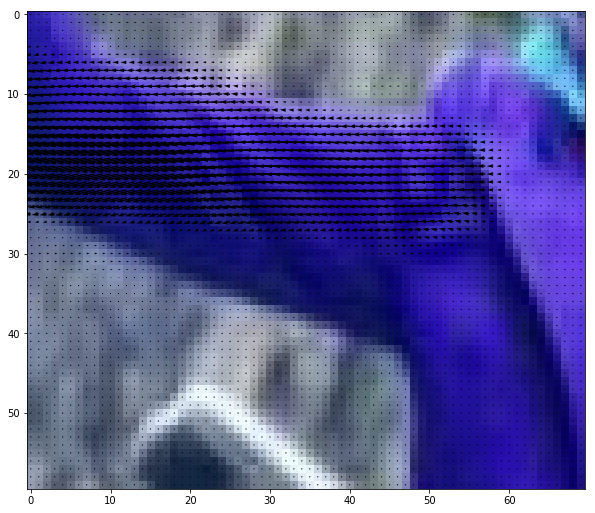

In [291]:
plt.figure(figsize=[10, 10])
plt.quiver(pafs[160:220, 350:420, 14], pafs[160:220, 350:420, 15])
plt.imshow(cv2.resize(img, (776,512))[160:220, 350:420])

In [ ]:
total_keypoints_num = 0
all_keypoints_by_type = []
for kpt_idx in range(num_keypoints):  # 19th for bg
    total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

In [ ]:


total_keypoints_num = 0
all_keypoints_by_type = []
for kpt_idx in range(num_keypoints):  # 19th for bg
    total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs, demo=True)
for kpt_id in range(all_keypoints.shape[0]):
    all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
    all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
current_poses = []
for n in range(len(pose_entries)):
    if len(pose_entries[n]) == 0:
        continue
    pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
    for kpt_id in range(num_keypoints):
        if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
            pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
            pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
    pose = Pose(pose_keypoints, pose_entries[n][18])
    current_poses.append(pose)

if track:
    track_poses(previous_poses, current_poses, smooth=smooth)
    previous_poses = current_poses
for i, pose in enumerate(current_poses):
    pose.draw(img, np.array(colormap[i % len(colormap)])*255)


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
key = cv2.waitKey(delay)
if key == 27:  # esc
    return
elif key == 112:  # 'p'
    if delay == 33:
        delay = 0
    else:
        delay = 33